The objective of this notebook is to create the fine-tune the models to be used

PyTorch version: 2.6.0+cpu
CUDA available: False
Dataset path: C:\SIT\SIT Y2 T1\AAI3001-Computer Vision and Deep Learning\CV Project\CVDL-P1-16-Group-Project\Datasets\shirts
✅ Dataset already organized!
   Train: 1628 images
   Test: 365 images

Dataset is ready for training!
Found 1 classes: ['shirts']
  shirts: 3256 images
Total samples: 3256
Found 1 classes: ['shirts']
  shirts: 730 images
Total samples: 730

DATASET SUMMARY
Classes: ['shirts']
Number of classes: 1
Training samples: 3256
Test samples: 730

Class distribution (training):
  shirts: 3256 images (100.0%)

✅ Data loaders created (batch size: 16)


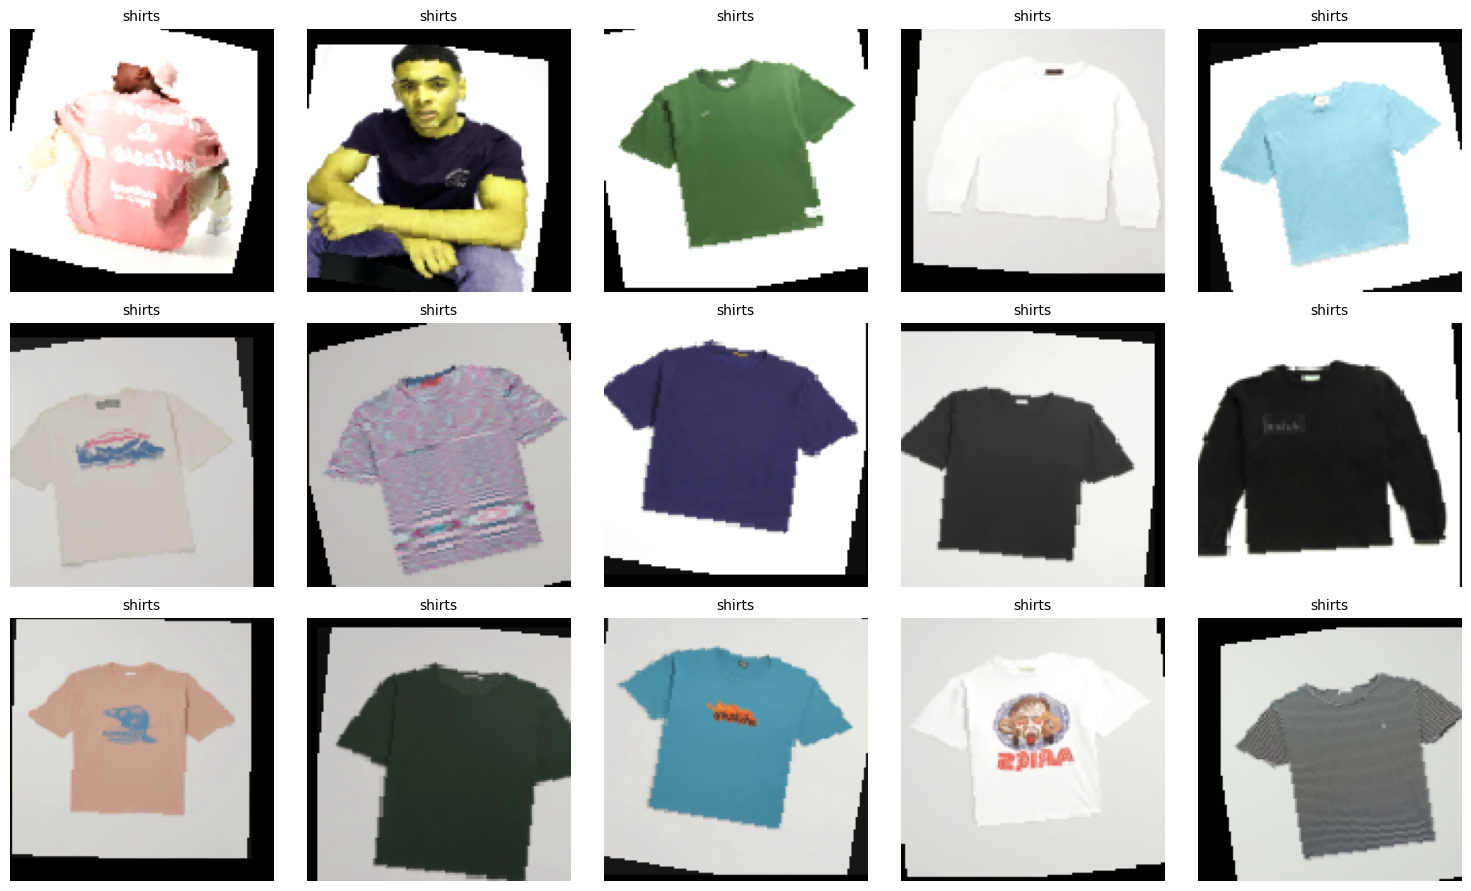

✅ Sample images saved as 'dataset_samples.png'
Using device: cpu

Model Architecture:
GarmentCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)

Parameters:
  Total: 4,218,625
  Trainable: 4,218,625

STARTING TRAINING

Epoch [1/10]
  Train Loss: 0.0000, Train Acc: 100.00%
  Test Loss: 0.0000, T

KeyboardInterrupt: 

In [17]:
# Cell 1: Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from pathlib import Path
import random
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

DATASET_PATH = r'C:\SIT\SIT Y2 T1\AAI3001-Computer Vision and Deep Learning\CV Project\CVDL-P1-16-Group-Project\Datasets\shirts'
print(f"Dataset path: {DATASET_PATH}")

# Cell 3: Custom Dataset Class
class CustomGarmentDataset(Dataset):
    """Custom dataset for garment images"""
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir: Path to dataset (e.g., 'datasets/shirts/train')
            transform: Optional transform to be applied on images
        """
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.samples = []
        self.classes = []
        
        # Get all class folders
        class_dirs = sorted([d for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {cls.name: idx for idx, cls in enumerate(class_dirs)}
        self.classes = [cls.name for cls in class_dirs]
        
        print(f"Found {len(self.classes)} classes: {self.classes}")
        
        # Load all images
        for class_dir in class_dirs:
            class_name = class_dir.name
            class_idx = self.class_to_idx[class_name]
            
            # Support multiple image formats
            image_files = []
            for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
                image_files.extend(class_dir.glob(ext))
            
            for img_path in image_files:
                self.samples.append({
                    'path': img_path,
                    'class_name': class_name,
                    'class_idx': class_idx
                })
            
            print(f"  {class_name}: {len(image_files)} images")
        
        print(f"Total samples: {len(self.samples)}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Load image
        try:
            image = Image.open(sample['path']).convert('RGB')
        except Exception as e:
            print(f"Error loading {sample['path']}: {e}")
            image = Image.new('RGB', (128, 128), color='white')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, sample['class_idx']
    
    def get_class_counts(self):
        """Get number of samples per class"""
        counts = {}
        for sample in self.samples:
            class_name = sample['class_name']
            counts[class_name] = counts.get(class_name, 0) + 1
        return counts

# Cell 4: Auto-Organize Dataset Function (Windows-Safe Version)
def auto_organize_dataset(source_dir, train_ratio=0.8):
    """
    Automatically organize flat image directory into train/test split
    Windows-safe version with better error handling
    """
    source_dir = Path(source_dir)
    
    # Check if directory exists
    if not source_dir.exists():
        print(f"❌ Directory not found: {source_dir}")
        return False
    
    # Define output directories
    train_dir = source_dir / 'train' / 'shirts'
    test_dir = source_dir / 'test' / 'shirts'
    
    # Check if already organized
    if train_dir.exists() and test_dir.exists():
        train_count = len(list(train_dir.glob('*')))
        test_count = len(list(test_dir.glob('*')))
        
        if train_count > 0 and test_count > 0:
            print("✅ Dataset already organized!")
            print(f"   Train: {train_count} images")
            print(f"   Test: {test_count} images")
            return True
    
    print("📁 Organizing dataset with 80/20 split...")
    
    # Get all image files from root directory only
    image_extensions = ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']
    all_images = []
    
    # Get all files in the directory
    for item in source_dir.iterdir():
        if item.is_file() and item.suffix in image_extensions:
            # Double check file still exists before adding
            if item.exists():
                all_images.append(item)
    
    if len(all_images) == 0:
        print(f"❌ No images found in {source_dir}")
        print("\nDirectory contents:")
        for item in list(source_dir.iterdir())[:10]:
            print(f"  - {item.name}")
        return False
    
    print(f"Found {len(all_images)} images")
    
    # Shuffle for random split
    random.seed(42)
    random.shuffle(all_images)
    
    # Calculate split point
    split_idx = int(len(all_images) * train_ratio)
    train_images = all_images[:split_idx]
    test_images = all_images[split_idx:]
    
    print(f"Splitting: {len(train_images)} train, {len(test_images)} test")
    
    # Create directories
    train_dir.mkdir(parents=True, exist_ok=True)
    test_dir.mkdir(parents=True, exist_ok=True)
    
    # Copy instead of move (safer)
    import shutil
    
    print("Copying images to train folder...")
    moved_count = 0
    for img in train_images:
        try:
            if img.exists():  # Double check before copying
                dest = train_dir / img.name
                shutil.copy2(str(img), str(dest))
                moved_count += 1
        except Exception as e:
            print(f"  ⚠️ Could not copy {img.name}: {e}")
    
    print(f"  Copied {moved_count}/{len(train_images)} images")
    
    print("Copying images to test folder...")
    moved_count = 0
    for img in test_images:
        try:
            if img.exists():  # Double check before copying
                dest = test_dir / img.name
                shutil.copy2(str(img), str(dest))
                moved_count += 1
        except Exception as e:
            print(f"  ⚠️ Could not copy {img.name}: {e}")
    
    print(f"  Copied {moved_count}/{len(test_images)} images")
    
    # Now delete original files (optional - comment out if you want to keep originals)
    print("\nCleaning up original files...")
    deleted = 0
    for img in all_images:
        try:
            if img.exists():
                img.unlink()
                deleted += 1
        except Exception as e:
            print(f"  ⚠️ Could not delete {img.name}: {e}")
    
    print(f"  Deleted {deleted} original files")
    
    print("✅ Dataset organized successfully!")
    print(f"   Train: {train_dir}")
    print(f"   Test: {test_dir}")
    
    return True

# Run auto-organize
dataset_source = r'C:\SIT\SIT Y2 T1\AAI3001-Computer Vision and Deep Learning\CV Project\CVDL-P1-16-Group-Project\Datasets\shirts'

if auto_organize_dataset(DATASET_PATH, train_ratio=0.8):
    print("\n" + "="*60)
    print("Dataset is ready for training!")
    print("="*60)


# Cell 5: Define Transforms
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1)
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# In Cell 6:
train_dataset = CustomGarmentDataset(
    root_dir=f'{DATASET_PATH}/train',
    transform=train_transform
)

test_dataset = CustomGarmentDataset(
    root_dir=f'{DATASET_PATH}/test',
    transform=test_transform
)


class_names = train_dataset.classes
num_classes = len(class_names)

print(f"\n{'='*60}")
print("DATASET SUMMARY")
print(f"{'='*60}")
print(f"Classes: {class_names}")
print(f"Number of classes: {num_classes}")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"\nClass distribution (training):")
for class_name, count in train_dataset.get_class_counts().items():
    percentage = (count / len(train_dataset)) * 100
    print(f"  {class_name}: {count} images ({percentage:.1f}%)")
print(f"{'='*60}\n")

# Create data loaders
batch_size = 16
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=0
)

print(f"✅ Data loaders created (batch size: {batch_size})")

# Cell 7: Visualize Sample Images
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.flatten()

for i in range(15):
    if i < len(train_dataset):
        img, label = train_dataset[i]
        
        # Denormalize
        img = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(class_names[label], fontsize=10)
        axes[i].axis('off')

plt.tight_layout()
plt.savefig('dataset_samples.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Sample images saved as 'dataset_samples.png'")

# In Cell 8, modify the model to be smaller:
class GarmentCNN(nn.Module):
    def __init__(self, num_classes):
        super(GarmentCNN, self).__init__()
        
        # Smaller architecture - fewer layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # Reduced from 32
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # Reduced from 64
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Reduced from 128
        self.bn3 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        
        # After 3 pooling: 128 -> 64 -> 32 -> 16
        self.fc1 = nn.Linear(64 * 16 * 16, 256)  # Smaller FC layers
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        x = x.view(-1, 64 * 16 * 16)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


# Cell 9: Initialize Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = GarmentCNN(num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=True
)

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Architecture:")
print(model)
print(f"\nParameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")

# Cell 10: Training Functions
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# Cell 11: Training Loop
num_epochs = 10
train_losses = []
train_accs = []
test_losses = []
test_accs = []
best_test_acc = 0.0

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60 + "\n")

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    scheduler.step(test_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'  Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), 'garment_classifier_best.pth')
        print(f'  ✅ New best model saved! (Test Acc: {test_acc:.2f}%)')
    print()

print(f"\n{'='*60}")
print(f"🎉 TRAINING COMPLETED!")
print(f"{'='*60}")
print(f"Best test accuracy: {best_test_acc:.2f}%")

# Cell 12: Plot Training History
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(test_losses, label='Test Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Test Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

ax2.plot(train_accs, label='Train Accuracy', linewidth=2)
ax2.plot(test_accs, label='Test Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Test Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Training history saved as 'training_history.png'")

# Cell 13: Save Model and Checkpoint
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
    'class_names': class_names,
    'num_classes': num_classes,
    'best_test_acc': best_test_acc,
    'train_losses': train_losses,
    'train_accs': train_accs,
    'test_losses': test_losses,
    'test_accs': test_accs
}, 'garment_classifier_checkpoint.pth')

print("\n✅ Model saved:")
print("  - garment_classifier_best.pth (weights only)")
print("  - garment_classifier_checkpoint.pth (full checkpoint)")

# Cell 14: Test Predictions
def predict_image(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0).to(device)
        output = model(image_tensor)
        probabilities = F.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class].item()
    return predicted_class, confidence, probabilities[0]

# Visualize predictions
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

for i in range(10):
    idx = np.random.randint(len(test_dataset))
    img_tensor, true_label = test_dataset[idx]
    
    pred_label, confidence, probs = predict_image(model, img_tensor, device)
    
    # Denormalize
    img = img_tensor.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    axes[i].imshow(img)
    color = 'green' if pred_label == true_label else 'red'
    axes[i].set_title(
        f'True: {class_names[true_label]}\n'
        f'Pred: {class_names[pred_label]}\n'
        f'Conf: {confidence:.1%}',
        color=color,
        fontsize=9
    )
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('prediction_examples.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Predictions saved as 'prediction_examples.png'")

# Cell 15: Confusion Matrix
def get_all_predictions(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_labels), np.array(all_preds)

y_true, y_pred = get_all_predictions(model, test_loader, device)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Confusion matrix saved as 'confusion_matrix.png'")

# Cell 16: Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names))

# Cell 17: Summary
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Dataset: {dataset_source}")
print(f"Total images: {len(train_dataset) + len(test_dataset)}")
print(f"Training images: {len(train_dataset)}")
print(f"Test images: {len(test_dataset)}")
print(f"Number of classes: {num_classes}")
print(f"Classes: {class_names}")
print(f"\nTraining Configuration:")
print(f"  Epochs: {num_epochs}")
print(f"  Batch size: {batch_size}")
print(f"  Learning rate: 0.001")
print(f"  Optimizer: Adam")
print(f"\nResults:")
print(f"  Best test accuracy: {best_test_acc:.2f}%")
print(f"  Final train accuracy: {train_accs[-1]:.2f}%")
print(f"  Final test accuracy: {test_accs[-1]:.2f}%")
print(f"\nSaved Files:")
print(f"  - garment_classifier_best.pth")
print(f"  - garment_classifier_checkpoint.pth")
print(f"  - dataset_samples.png")
print(f"  - training_history.png")
print(f"  - prediction_examples.png")
print(f"  - confusion_matrix.png")
print("="*60)
